C:\Users\Seamus-admin\AppData\Local\Temp\2\ipykernel_16064\1225142174.py:5: DtypeWarning: Columns (29,30,34,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(



Average xG per corner (Horsens): 0.031
Total xG from corner (Horsens): 1.456
Number of corners (Horsens): 47


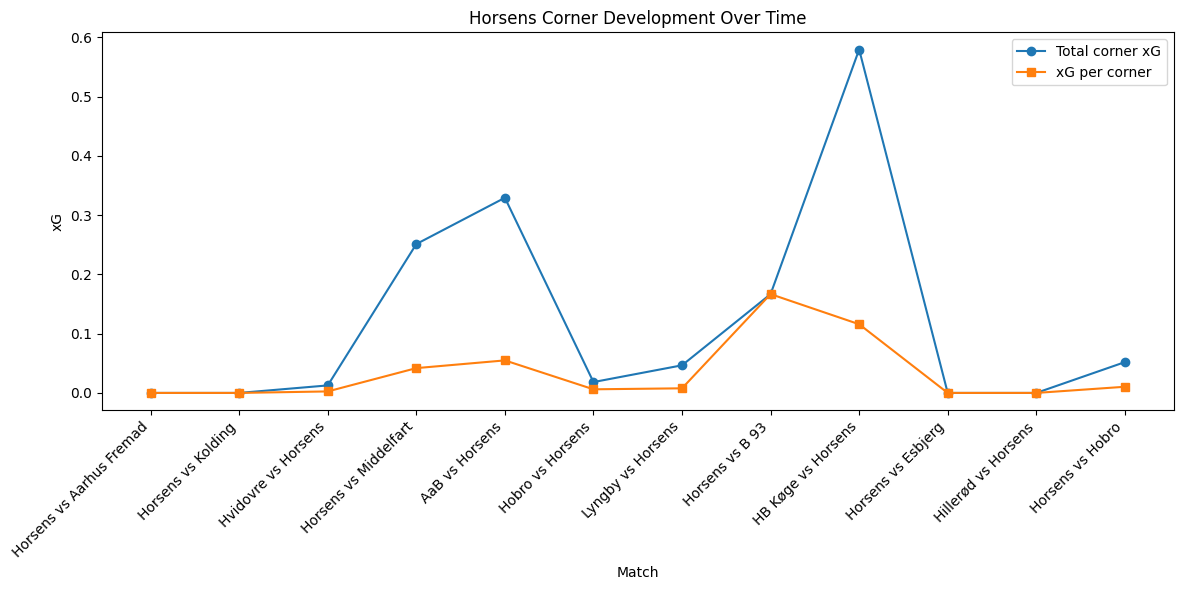


=== League table: Corner (xG per piece, total xG, count) ===
    team_name  xG_per_piece  xG_total  corner_taken
        Hobro         0.064     3.664            57
     Hvidovre         0.040     2.106            53
     Hillerød         0.037     1.919            52
      Horsens         0.031     1.456            47
          AaB         0.028     1.909            67
      HB Køge         0.027     1.028            38
         B 93         0.026     1.505            57
      Esbjerg         0.025     1.400            55
Aarhus Fremad         0.023     1.582            68
   Middelfart         0.021     0.911            44
       Lyngby         0.019     0.984            51
      Kolding         0.016     1.110            69

Average xG per freekick (Horsens): 0.036
Total xG from freekick (Horsens): 0.897
Number of freekicks (Horsens): 25


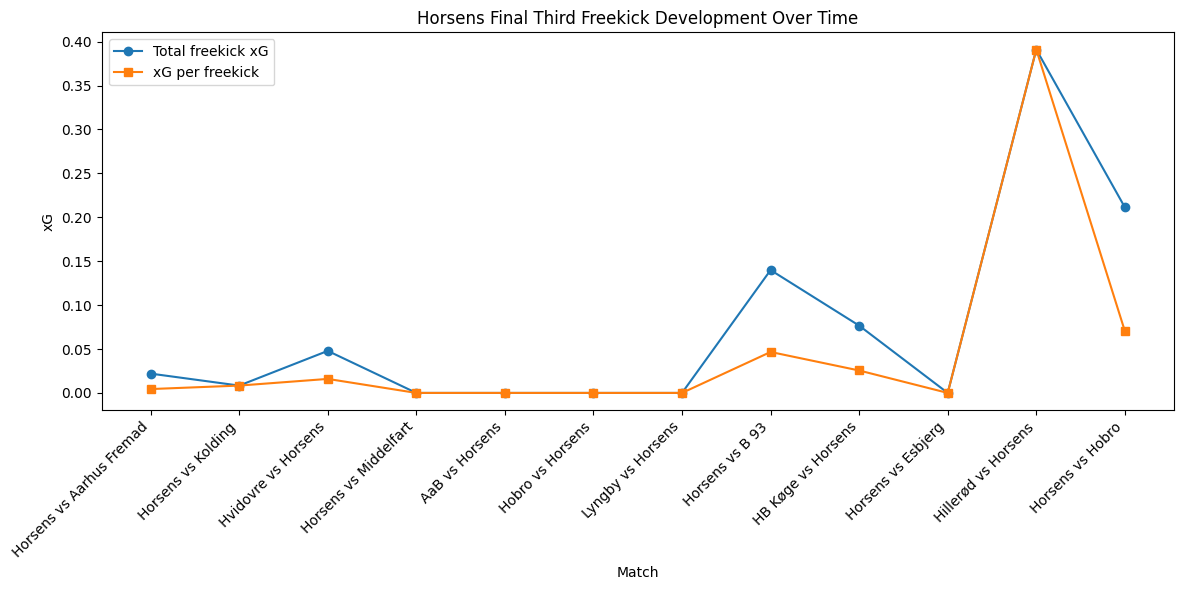


=== League table: Final Third Freekick (xG per piece, total xG, count) ===
    team_name  xG_per_piece  xG_total  freekick_taken
     Hvidovre         0.104     1.880              18
      HB Køge         0.062     1.232              20
      Kolding         0.059     1.301              22
       Lyngby         0.053     1.474              28
      Horsens         0.036     0.897              25
          AaB         0.034     0.707              21
      Esbjerg         0.032     0.729              23
        Hobro         0.032     0.747              23
Aarhus Fremad         0.023     0.562              24
     Hillerød         0.018     0.465              26
   Middelfart         0.007     0.150              20
         B 93         0.004     0.089              21

Average xG per long throw-in (Horsens): 0.006
Total xG from long throw-ins (Horsens): 0.301
Number of long throw-ins (Horsens): 50


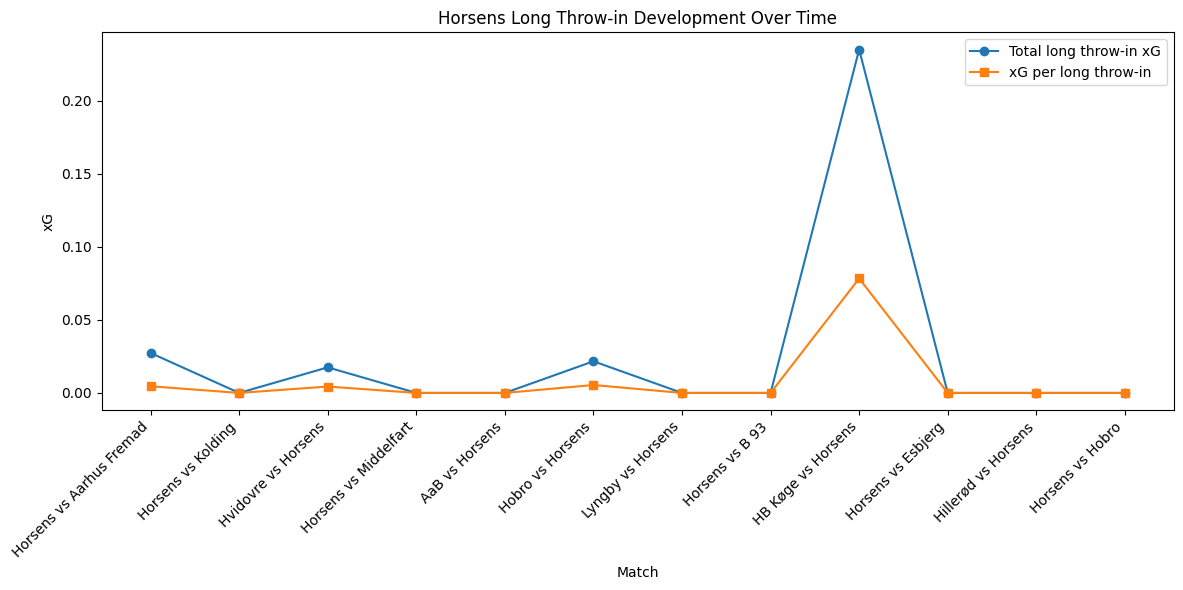


=== League table: Long Throw-ins (xG per throw-in, total xG, count) ===
    team_name  xG_per_throwin  xG_total  long_throwins_taken
      HB Køge           0.031     1.789                   58
     Hillerød           0.016     0.470                   29
        Hobro           0.015     0.832                   56
      Kolding           0.012     0.684                   59
     Hvidovre           0.010     0.571                   58
       Lyngby           0.008     0.377                   49
      Esbjerg           0.007     0.483                   67
Aarhus Fremad           0.006     0.311                   48
      Horsens           0.006     0.301                   50
         B 93           0.005     0.268                   52
   Middelfart           0.005     0.319                   67
          AaB           0.002     0.072                   43


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Load data ---
df = pd.read_csv(
    r'C:\Users\Seamus-admin\Documents\GitHub\AC-Horsens-First-Team\DNK_1_Division_2025_2026\set_piece_DNK_1_Division_2025_2026.csv'
)

# Function to process any set piece type
def process_set_piece(df, piece_type, extra_filter=None, title="Set Piece"):
    # --- Filter specific set piece type ---
    pieces = df[df['set_piece_type'] == piece_type].copy()
    if piece_type == "freekick":
        pieces = pieces[pieces['x'] > 66]
   
    # Apply extra filter if provided
    if extra_filter is not None:
        pieces = pieces.query(extra_filter)
    
    # Sort so IDs are sequential
    pieces = pieces.sort_values(['match_id', 'team_name', 'date', 'set_piece_index'])
    
    # Create running unique set piece ID (new ID whenever index == 1)
    pieces['set_piece_uid'] = (pieces['set_piece_index'] == 1).cumsum()
    
    # Corner type is only relevant for corners, but keep column for consistency
    pieces['corner_type'] = pieces.apply(
        lambda row: 'inswinger' if row.get('223.0', 0) == 1 
        else ('outswinger' if row.get('224.0', 0) == 1 else 'other'),
        axis=1
    )
    
    # Aggregate to set-piece level (xG only from 321.0)
    agg_pieces = (
        pieces.groupby(['set_piece_uid', 'match_id', 'team_name', 'date', 'label'])
        .agg(
            corner_type=('corner_type', lambda x: 'inswinger' if 'inswinger' in x.values 
                         else 'outswinger' if 'outswinger' in x.values else 'other'),
            xG=('321.0', 'sum')   # total xG from shots in this set piece
        )
        .reset_index()
    )
    
    # --- Horsens only ---
    horsens_pieces = agg_pieces[agg_pieces['team_name'] == 'Horsens']
    
    # Horsens stats
    xg_per_piece = horsens_pieces['xG'].mean()
    xg_total_pieces = horsens_pieces['xG'].sum()
    num_pieces_horsens = horsens_pieces['set_piece_uid'].nunique()
    
    print(f"\nAverage xG per {piece_type} (Horsens):", round(xg_per_piece, 3))
    print(f"Total xG from {piece_type} (Horsens):", round(xg_total_pieces, 3))
    print(f"Number of {piece_type}s (Horsens):", num_pieces_horsens)
    
    # Over time
    xg_over_time = horsens_pieces.groupby(['date', 'label'])['xG'].sum().reset_index()
    xg_per_piece_over_time = horsens_pieces.groupby(['date', 'label'])['xG'].mean().reset_index()
    
    # Plot Horsens development over time
    plt.figure(figsize=(12,6))
    plt.plot(xg_over_time['label'], xg_over_time['xG'], marker='o', label=f"Total {piece_type} xG")
    plt.plot(xg_per_piece_over_time['label'], xg_per_piece_over_time['xG'], marker='s', label=f"xG per {piece_type}")
    
    plt.title(f"Horsens {title} Development Over Time")
    plt.xlabel("Match")
    plt.ylabel("xG")
    plt.legend()
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
    
    # --- League-wide rankings with counts ---
    xg_per_piece_team = agg_pieces.groupby('team_name')['xG'].mean().reset_index()
    xg_total_pieces_team = agg_pieces.groupby('team_name')['xG'].sum().reset_index()
    pieces_count_team = (
        agg_pieces.groupby('team_name')['set_piece_uid']
        .nunique()
        .reset_index()
        .rename(columns={'set_piece_uid': f'{piece_type}_taken'})
    )
    
    xg_table = (
        xg_per_piece_team
        .merge(xg_total_pieces_team, on='team_name', suffixes=('_per_piece', '_total'))
        .merge(pieces_count_team, on='team_name')
        .round(3)
        .sort_values('xG_per_piece', ascending=False)
    )
    
    print(f"\n=== League table: {title} (xG per piece, total xG, count) ===")
    print(xg_table.to_string(index=False))
    
    return agg_pieces


# --- Process corners ---
agg_corners = process_set_piece(df, "corner", title="Corner")

# --- Process freekicks ---
agg_freekicks = process_set_piece(
    df, 
    "freekick", 
    title="Final Third Freekick"
)


# --- Long throw-ins in final third ---
throwins = df[df['set_piece_type'] == 'throw_in'].copy()

# Make sure numeric
throwins['x'] = pd.to_numeric(throwins['x'], errors='coerce')
throwins['212.0'] = pd.to_numeric(throwins['212.0'], errors='coerce')

# Sort
throwins = throwins.sort_values(['match_id', 'team_name', 'date', 'set_piece_index'])

# Create running set piece UID
throwins['set_piece_uid'] = (throwins['set_piece_index'] == 1).cumsum()

# Identify long throw-ins in final third
long_throwins = throwins[(throwins['x'] > 66) & (throwins['212.0'] > 15)]
long_throwin_ids = long_throwins['set_piece_uid'].unique()

# Get all actions from those throw-in sequences
long_throwin_sequences = throwins[throwins['set_piece_uid'].isin(long_throwin_ids)].copy()

# Aggregate
agg_long_throwins = (
    long_throwin_sequences.groupby(['set_piece_uid', 'match_id', 'team_name', 'date', 'label'])
    .agg(xG=('321.0', 'sum'))
    .reset_index()
)

# Horsens stats
horsens_long_throwins = agg_long_throwins[agg_long_throwins['team_name'] == 'Horsens']
xg_per_throwin = horsens_long_throwins['xG'].mean()
xg_total_throwins = horsens_long_throwins['xG'].sum()
num_throwins_horsens = horsens_long_throwins['set_piece_uid'].nunique()

print("\nAverage xG per long throw-in (Horsens):", round(xg_per_throwin, 3))
print("Total xG from long throw-ins (Horsens):", round(xg_total_throwins, 3))
print("Number of long throw-ins (Horsens):", num_throwins_horsens)

# Over time plot
xg_over_time_throwin = horsens_long_throwins.groupby(['date', 'label'])['xG'].sum().reset_index()
xg_per_throwin_over_time = horsens_long_throwins.groupby(['date', 'label'])['xG'].mean().reset_index()

plt.figure(figsize=(12,6))
plt.plot(xg_over_time_throwin['label'], xg_over_time_throwin['xG'], marker='o', label="Total long throw-in xG")
plt.plot(xg_per_throwin_over_time['label'], xg_per_throwin_over_time['xG'], marker='s', label="xG per long throw-in")

plt.title("Horsens Long Throw-in Development Over Time")
plt.xlabel("Match")
plt.ylabel("xG")
plt.legend()
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# --- League-wide long throw-in table ---
xg_per_throwin_team = agg_long_throwins.groupby('team_name')['xG'].mean().reset_index()
xg_total_throwins_team = agg_long_throwins.groupby('team_name')['xG'].sum().reset_index()
throwins_count_team = (
    agg_long_throwins.groupby('team_name')['set_piece_uid']
    .nunique()
    .reset_index()
    .rename(columns={'set_piece_uid': 'long_throwins_taken'})
)

xg_table_throwins = (
    xg_per_throwin_team
    .merge(xg_total_throwins_team, on='team_name', suffixes=('_per_throwin', '_total'))
    .merge(throwins_count_team, on='team_name')
    .round(3)
    .sort_values('xG_per_throwin', ascending=False)
)

print("\n=== League table: Long Throw-ins (xG per throw-in, total xG, count) ===")
print(xg_table_throwins.to_string(index=False))
